#  3: Dimensionality Reduction

Here is the third part and it is about dimentionality reduction. How to map high-dimentional data into low-dimensional space is an interesting topic in machine learning field. And also, it is related to another hot topic -- unsupervised learning. Now, in this section, we are going to learn two different methods for this question.

* Principal Component Analysis (PCA)
* t-Distributed Stochastic Neighbor Embedding (t-SNE) 

In [31]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from ecbm4040.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

We will use the CIFAR-10 dataset.

In [45]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.reshape([50000,3,32,32]).transpose((0,2,3,1))
X_test = X_test.reshape([10000,3,32,32]).transpose((0,2,3,1))
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
# Test data: 10000 samples from original test set: 1~10000
# Development data (for gradient check): 100 from the train set: 1~49000 #TODOTA is this 100 or 1000?
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
(49000, 32, 32, 3) (1000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Development data shape: (100, 32, 32, 3)
Development data shape (100,)


## Part 1: Principal Component Analysis (PCA)

The code is in **./ecbm4040/features/pca.py**.

### Naive PCA

In [3]:
from ecbm4040.features.pca import pca_naive

X_patch = X_train[:,:,:,0]
X_patch = np.reshape(X_patch, (X_patch.shape[0], -1))

In [4]:
X_patch.shape

(49000, 1024)

In [5]:
# Start PCA
K = 200
P, T = pca_naive(X_patch, K)

In [11]:
sum(T[0:200])

0.96286265230446588

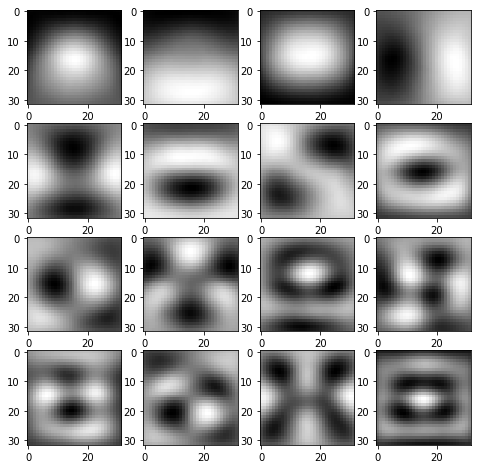

In [6]:
# Visualize P
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = np.reshape(P[r*i+j], [32,32])
        axarr[i][j].imshow(img, cmap="gray")

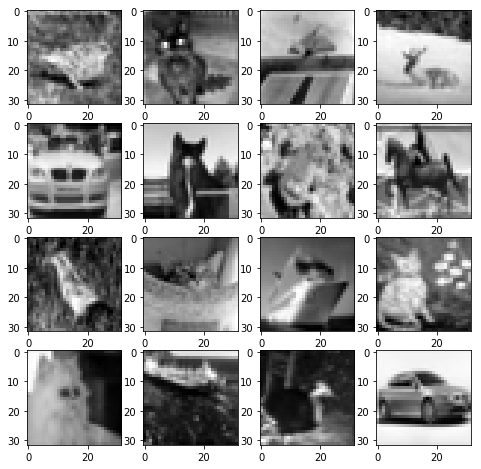

In [7]:
# Select a small set of images for test
num_training = 50000
num_pca = 16
mask = np.random.choice(num_training, num_pca, replace=False)
X_pca = X_train[mask,:,:,0]

# Visualize one channel of images 
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_pca[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

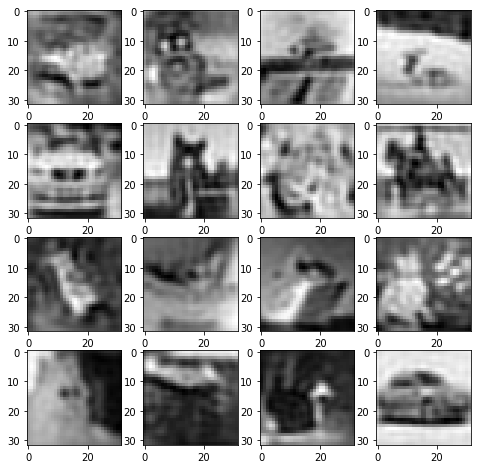

In [8]:
# Reduce dimension with P
X_features = []
for n in range(num_pca):
    img = X_pca[n]
    feature = np.dot(P, np.reshape(img, (-1,)))
    X_features.append(feature)

# Reconstruct image
X_recon = []
for n in range(num_pca):
    feature = X_features[n]
    img = np.reshape(np.dot(feature, P), (32,32))
    X_recon.append(img)

# Visualize results
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_recon[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

### PCA + Neural network

We use PCA to preprocess images before training a neural network: 

1. Do PCA preprocessing on each channel of the original image separately.
2. Stack PCA features from three channels into one vector, and use that vector as an input for MLP.
3. Train the MLP and show the results. 

In [18]:
num_validation

1000

In [34]:
y_val_1=y_val

In [48]:
print(y_val)

[8 9 4 9 0 5 0 8 2 3 7 8 9 4 5 3 2 5 0 7 2 1 1 4 4 8 9 4 6 9 4 9 3 5 6 9 9
 7 7 6 1 6 8 8 3 1 6 7 7 2 0 7 5 2 3 4 6 9 7 6 1 6 6 7 9 9 1 0 2 2 5 7 9 9
 9 1 6 4 3 3 1 3 6 3 1 1 9 9 6 3 8 0 0 2 6 6 1 4 4 2 0 2 8 7 2 5 2 0 8 7 6
 5 9 5 4 8 7 3 5 6 5 1 1 9 9 9 7 8 0 6 0 3 7 7 8 6 1 1 4 7 3 7 3 3 8 6 3 9
 1 0 1 1 8 2 4 5 2 3 9 2 8 8 7 1 0 8 8 9 0 0 3 6 5 1 0 7 0 8 3 2 8 9 8 7 8
 5 1 4 5 0 3 8 6 9 9 8 1 3 7 4 6 8 7 7 4 0 9 4 9 6 6 9 6 4 6 5 8 9 3 0 8 1
 3 3 2 1 7 3 9 7 1 7 1 3 1 8 0 4 9 1 3 7 5 4 9 0 7 8 2 9 8 4 4 8 5 0 2 8 8
 5 9 6 7 0 7 6 9 5 2 1 7 5 7 3 2 2 0 7 9 6 3 7 2 1 9 6 1 9 5 6 2 8 4 7 5 9
 6 2 3 3 9 5 6 0 5 6 3 6 0 7 7 6 6 1 1 5 5 4 4 3 6 8 3 7 5 3 1 5 2 2 8 2 7
 5 5 7 3 1 9 0 0 7 2 6 0 1 0 8 1 0 7 6 4 6 1 4 1 2 8 0 9 6 1 7 6 4 3 3 3 9
 9 0 8 0 8 0 1 7 8 8 5 1 6 1 3 9 3 0 8 8 4 7 1 8 6 2 7 2 9 5 8 1 4 9 6 9 6
 7 3 1 0 1 6 7 4 8 1 9 6 2 0 4 5 0 3 9 1 9 5 8 3 5 2 6 8 1 1 5 1 0 6 0 9 3
 3 8 8 1 3 2 2 7 5 9 7 5 7 2 2 6 9 9 6 3 6 8 3 5 3 1 7 2 5 8 5 4 7 9 3 8 4
 3 5 1 5 7 1 1 4 1 0 1 3 

In [50]:
print(y_val)

[1 0 2 1 5 3 5 3 4 0 5 5 2 0 2 2 4 9 4 3 7 1 6 4 0 2 0 6 3 7 1 9 0 9 9 7 1
 3 4 3 3 7 8 6 8 3 4 6 5 6 5 9 3 1 0 7 5 6 3 0 7 9 3 3 2 6 7 6 4 0 6 0 6 2
 2 1 8 5 1 6 4 8 2 5 9 3 1 4 3 2 2 4 2 2 0 2 0 3 9 7 0 2 2 6 7 0 9 8 0 0 5
 7 3 1 5 1 9 2 3 0 8 9 1 9 8 8 9 8 1 9 0 3 3 8 3 5 0 2 1 5 9 1 6 4 3 0 2 0
 0 7 9 9 9 7 6 5 8 3 8 4 6 5 3 4 8 9 7 6 8 2 3 9 4 1 0 8 6 7 9 4 7 5 1 3 6
 1 3 0 6 5 6 4 9 5 2 4 9 0 7 5 3 6 4 6 7 2 6 5 5 0 9 4 0 8 6 1 4 0 6 7 5 4
 2 4 1 8 9 8 4 6 6 9 2 3 1 4 7 7 9 0 5 6 2 3 2 5 0 8 3 8 2 2 0 8 0 7 7 0 7
 2 9 8 3 1 1 7 0 6 9 1 2 8 7 8 5 1 9 6 9 1 0 8 2 7 9 3 8 2 2 0 2 0 9 1 1 0
 3 8 6 8 2 5 5 5 7 4 3 7 9 4 1 8 1 9 2 3 8 0 0 5 8 2 1 2 0 6 3 0 5 9 5 3 9
 8 4 8 8 6 4 9 9 5 8 7 2 9 3 0 2 7 0 4 6 9 2 0 5 7 1 0 4 6 5 0 2 2 2 4 3 6
 2 9 8 6 8 1 3 3 0 8 8 5 7 5 2 9 7 9 2 0 3 2 2 8 4 5 6 5 5 4 6 6 3 5 2 9 6
 4 9 3 3 5 5 4 2 0 0 2 5 0 7 5 5 7 0 4 3 2 0 4 0 9 8 4 9 9 7 5 7 9 8 1 9 3
 5 8 6 4 6 9 9 9 3 7 5 9 7 8 0 8 6 9 8 6 7 1 7 7 9 8 0 9 2 6 5 8 0 5 4 3 2
 8 2 6 4 0 7 7 4 0 7 8 0 

In [52]:
from ecbm4040.train_funcs import train, test
from ecbm4040.classifiers.mlp import MLP

#pca preprocessing -> mlp classification

def preprocessing_pca(X,K):
    X_patch_1 = X[:,:,:,0]
    X_patch_2 = X[:,:,:,1]
    X_patch_3 = X[:,:,:,2]

    X_patch_1 = np.reshape(X_patch_1, (X_patch_1.shape[0], -1))
    X_patch_2 = np.reshape(X_patch_2, (X_patch_2.shape[0], -1))
    X_patch_3 = np.reshape(X_patch_3, (X_patch_3.shape[0], -1))

    # Start PCA
    K = 200
    P1, T1 = pca_naive(X_patch_1, K)
    P2, T2 = pca_naive(X_patch_2, K)
    P3, T3 = pca_naive(X_patch_3, K)
    
    X_patch = np.hstack((np.dot(X_patch_1,P1.T),np.dot(X_patch_2,P2.T),np.dot(X_patch_3,P3.T)))
    return(X_patch,P1,P2,P3)

X_patch_train,P1,P2,P3 = preprocessing_pca(X_train,K)

X_patch_1 = X_test[:,:,:,0]
X_patch_2 = X_test[:,:,:,1]
X_patch_3 = X_test[:,:,:,2]

X_patch_1 = np.reshape(X_patch_1, (X_patch_1.shape[0], -1))
X_patch_2 = np.reshape(X_patch_2, (X_patch_2.shape[0], -1))
X_patch_3 = np.reshape(X_patch_3, (X_patch_3.shape[0], -1))

X_patch_test = np.hstack((np.dot(X_patch_1,P1.T),np.dot(X_patch_2,P2.T),np.dot(X_patch_3,P3.T)))

X_patch_val = X_patch_train[-num_validation:]


In [70]:
model = MLP(input_dim=600, hidden_dims=[100,50], num_classes=10, reg=0.1, weight_scale=1e-2)

num_epoch = 30
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_patch_train, y_train, X_patch_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_patch_test, y_test)

number of batches for training: 245
epoch 1: valid acc = 0.157, new learning rate = 0.00095
epoch 2: valid acc = 0.173, new learning rate = 0.0009025
epoch 3: valid acc = 0.214, new learning rate = 0.000857375
epoch 4: valid acc = 0.262, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.263, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.287, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.318, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.347, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.348, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.354, new learning rate = 0.0005987369392383785
epoch 11: valid acc = 0.355, new learning rate = 0.0005688000922764595
epoch 12: valid acc = 0.36, new learning rate = 0.0005403600876626365
epoch 13: valid acc = 0.37, new learning rate = 0.0005133420832795047
epoch 14: valid acc = 0.374, new learning rate = 0.00048767497911552944
epoch 15: valid a

0.45050000000000001

Plot training, validation and test set accuracy.

In [1]:

plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.plot(range(30),[0.45]*30,label='final test accuracy')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

## Part 2: t-SNE (not graded)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR10. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [27]:
from ecbm4040.features.tsne import tsne

#### tSNE of original data

In [28]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test[random_select,:,:,0].reshape(500,1024).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.53800293452
The 100 th loop cost: 14.74796594930936, computation time: 2.2752180099487305
The 200 th loop cost: 1.1495461921648134, computation time: 4.5237531661987305
The 300 th loop cost: 1.1436445271340834, computation time: 6.723826169967651
The 400 th loop cost: 1.1435313481754976, computation time: 8.85843801498413
The 500 th loop cost: 1.143530740069774, computation time: 11.002559185028076
The 600 th loop cost: 1.143530736511861, computation time: 13.156534194946289
The 700 th loop cost: 1.1435307364909186, computation time: 15.299098014831543
The 800 th loop cost: 1.1435307364907694, computation time: 17.44902515411377
The 900 th loop cost: 1.143530736490766, computation time: 19.67706608772278
The 1000 th loop cost: 1.1435307364907656, computation time: 21.95286512374878
it takes 22.764039039611816 seconds


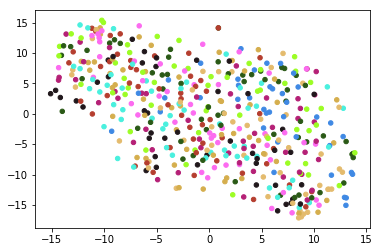

In [29]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, the tSNE of data after two-layer networks is shown as multiple clusters in a 2D panel.

In [32]:
# Define MLP model
model = MLP(input_dim=3072, hidden_dims=[100], num_classes=10, reg=0.1, weight_scale=1e-2)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245


/Users/nathantoubiana/KOSTIC/ecbm4040/layer_funcs.py:188: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


epoch 1: valid acc = 0.351, new learning rate = 0.00095
epoch 2: valid acc = 0.431, new learning rate = 0.0009025
epoch 3: valid acc = 0.479, new learning rate = 0.000857375
epoch 4: valid acc = 0.508, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.511, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.521, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.52, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.525, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.527, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.534, new learning rate = 0.0005987369392383785
test acc: 0.5037


0.50370000000000004

In [33]:
# run tSNE
X = X_test[random_select]
X = model.layers[0].feedforward(X)
X = model.layers[1].feedforward(X)
X_exp = np.exp(X)
X = X_exp / np.tile(np.sum(X_exp, axis=1, keepdims=True), 10)

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

0.187668581797
The 100 th loop cost: 11.071985187874658, computation time: 2.3936829566955566
The 200 th loop cost: 0.5037996033538442, computation time: 4.730288982391357
The 300 th loop cost: 0.489739128821699, computation time: 7.097949981689453
The 400 th loop cost: 0.48867566267299933, computation time: 9.4407479763031
The 500 th loop cost: 0.4886031868674546, computation time: 11.78285002708435
The 600 th loop cost: 0.48859573676293006, computation time: 14.127580881118774
The 700 th loop cost: 0.48859486471356495, computation time: 16.468291997909546
The 800 th loop cost: 0.4885947539044342, computation time: 18.819227933883667
The 900 th loop cost: 0.48859473910778667, computation time: 21.17939805984497
The 1000 th loop cost: 0.48859473709234835, computation time: 23.52723002433777
it takes 24.281365871429443 seconds


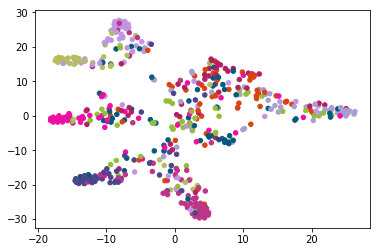

In [34]:
# visualize tSNE 2D representation of data after two hidden layers
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()